In [33]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np
# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns
# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval
# for grabbing individual cells
import more_itertools
# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
import xgboost
import shap

import re
from ast import literal_eval
from matplotlib import lines
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
# sns.set(font='helvetica')
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [4]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [5]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)

In [13]:
# saving data to stylized table for manuscript

print(telo_data.shape)

example = telo_data.copy()
example.rename({'timepoint':'pre-therapy sample origin', 
                'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)
example_8 = example[10:16].reset_index(drop=True)

# path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length dataframe.png'
# trp.render_mpl_table(example_8, col_width=4, path=path)

(128800, 4)


## Train/test split 

In [6]:
telo_test = telo_data.copy()

train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 
                                                                                                   'timepoint']])

## Initializing cleaning/model pipelines

In [14]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [15]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2, 
                     objective ='reg:squarederror', random_state=1)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [16]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

In [90]:
example8 = train_clean[['timepoint_2 irrad @ 4 Gy', 'individual telomeres', '4 C telo means']].copy()
example = example8.copy()
example.rename({'timepoint_2 irrad @ 4 Gy':'encoded sample origin', 
                'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)

example_8 = example[10:16].reset_index(drop=True)
path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length dataframe.png'
trp.render_mpl_table(example_8, col_width=4, path=path)

## Random GridSearch for pipeline/model params

In [121]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [122]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [123]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [124]:
# bayesian optimized model
# bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
#                        objective ='reg:squarederror', random_state=0, subsample=.9,
#                        gamma=1.7)

## Visualizing model objective

In [ ]:
# train_viz = train_set.copy()
# train_viz.sort_values(by=['patient id'], axis=0, ascending=True, inplace=True)
# trp.plot_individ_telos_ML_objective(df=train_viz, target='4 C telo means')

In [20]:
train_clean123 = clean_process_pipe.set_params(cleaner__drop_patient_id=True).fit_transform(train_set)
test_clean123 = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(test_set)

patient_info = test_clean123[['patient id', '4 C telo means']]
test_clean123.drop(['patient id', '4 C telo means'], axis=1, inplace=True)
preds = fit_xgb_model.predict(test_clean123)

In [21]:
predictions_df = pd.concat([test_clean123, patient_info, pd.DataFrame(preds)], axis=1)
predictions_df.rename({0:'predicted 4 C telo means'}, axis=1, inplace=True)

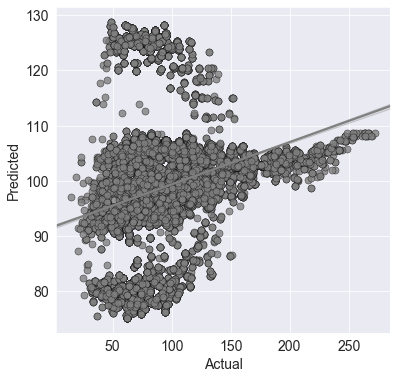

In [22]:
sns.set_color_codes()

plt.figure(figsize=(6,6))

ax = sns.regplot(x='individual telomeres', y='predicted 4 C telo means', 
                 scatter_kws={'s':50, 'edgecolor':'k', 'linewidth':0.5}, color='grey', data=predictions_df)


ax.set_xlabel("Actual", fontsize=14)
ax.set_ylabel("Predicted", fontsize=14)
ax.tick_params(labelsize=14)

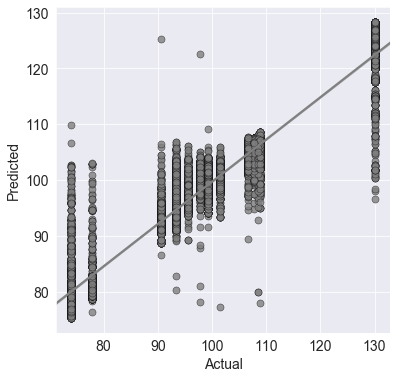

In [41]:
sns.set_color_codes()

plt.figure(figsize=(6,6))

ax = sns.regplot(x='4 C telo means', y='predicted 4 C telo means', 
                 scatter_kws={'s':50, 'edgecolor':'k', 'linewidth':0.5}, color='grey', data=predictions_df)


ax.set_xlabel("Actual", fontsize=14)
ax.set_ylabel("Predicted", fontsize=14)
ax.tick_params(labelsize=14)

## Cross validation; MAE & R2 score 

In [17]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.29298929 3.1956427  3.20833683 3.18717928 3.24455706] 

MEAN of MAE all folds: 3.2257410319760824
STD of MAE all folds: 0.03891579435139565

MAE of predict_y_test & y_test: 3.244669627394961
R2 between predict_y_test & y_test: 0.8852747065225033


In [100]:
# evaluating model based on N samples in training data
telo_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean.sample(n), test_set=test_clean,
                                                        target='4 C telo means',
                                                        model=model, cv=5, verbose=False)
    telo_row[0].append(n)
    telo_model_df += (telo_row)

In [101]:
model_metrics_n_train = pd.DataFrame(telo_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])
model_metrics_n_train['Features'] = model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
model_metrics_n_train['Features'] = 'individual telos, encoded samples'
model_metrics_n_train.drop(['Model', 'Features', 'Target'], axis=1, inplace=True)

# saving table for manuscript
# path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | per N training samples 100 to 100000.png'
# trp.render_mpl_table(model_metrics_n_train, col_width=4, path=path)

In [33]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                                                   model=fit_xgb_model, target='4 C telo means',
                                                                   clean_process_pipe=clean_process_pipe, verbose=True)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 99.23
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 104.75
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 96.64
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.51
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 123.41
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 100.93
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 104.13
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 105.08
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 97.62
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 104.79
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 80.50
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 94.58
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 9

Text(0.5, 1.0, 'XGBoost predictions of post-therapy mean telomere lengths')

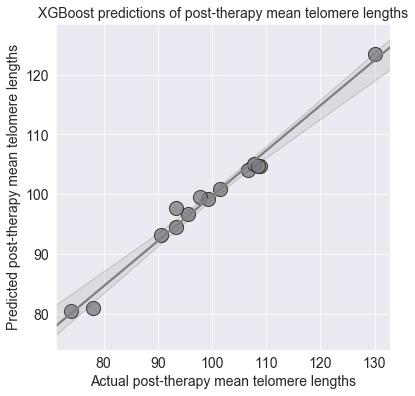

In [34]:
sns.set_color_codes()

plt.figure(figsize=(6,6))

ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, color='grey',)


ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy mean telomere lengths', fontsize=14, )
# plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C mean telos vs predicted.png', 
#             dpi=400, bbox_inches = "tight")

## Analysis of XGBoost performance when 1/2/3 of each patients is omitted from training data

In [3]:
# loading data
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)

telo_data_full = telo_data.copy()
train_full, test_full = train_test_split(telo_data_full, test_size=0.2, shuffle=True, 
                                         stratify=telo_data_full[['patient id', 'timepoint']])

both_dfs = []
for less_patient in [1, 2, 3]:
    all_data = pd.DataFrame()
    patient_ids = telo_data['patient id'].unique()
    for ind, val in enumerate(patient_ids):
        if less_patient == 2 and val == 16:
            break
        elif less_patient == 3 and val == 15:
            break
        else:
            patients = patient_ids[ind:ind+less_patient]
            telo_data_reduced = telo_data[~telo_data['patient id'].isin(patients)].copy()    
            train_set, test_set = train_test_split(telo_data_reduced, test_size=0.2, shuffle=True, 
                                                   stratify=telo_data_reduced[['patient id', 'timepoint']])

            clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                                           ('dummies', trp.make_dummies(drop_first=True)),
                                           ('cleaner', trp.clean_data(drop_patient_id=True))])

            # XGBoost model
            model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2, 
                                 objective ='reg:squarederror', random_state=1)

            train_clean = train_set.copy()
            test_clean = test_set.copy()
            train_clean = clean_process_pipe.fit_transform(train_clean)
            test_clean = clean_process_pipe.fit_transform(test_clean)

            # predicting mean telo telo post-therapy (4 C) using individual telos
            fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean, 
                                                                model=model, cv=5, verbose=False)
        #     print('\n')
            y_predict_list, y_true_list, patient_ids = trp.predict_target_4C_compare_actual(telo_data=telo_data_full, 
                                                                                            test_set=test_full, 
                                                                                            model=fit_xgb_model, 
                                                                                            target='4 C telo means',
                                                                                            clean_process_pipe=clean_process_pipe, 
                                                                                            verbose=False)

            temp_df = pd.DataFrame({'predicted vals':y_predict_list,
                                    'true vals':y_true_list,
                                    'patient ids':patient_ids})
            temp_df['less patient #'] = f'less patient #{patients}'
            all_data = pd.concat([all_data, temp_df], axis=0)

            print(f'passed PATIENT# {patients}')
    both_dfs.append(all_data)

MAE predicted vs. actual 4 C telo means: 2.71712894746855
R2 predicted vs. actual 4 C telo means: 0.9394262779525655
passed PATIENT# [1]
MAE predicted vs. actual 4 C telo means: 3.052730754109175
R2 predicted vs. actual 4 C telo means: 0.9209306333504489
passed PATIENT# [2]
MAE predicted vs. actual 4 C telo means: 2.853333158759404
R2 predicted vs. actual 4 C telo means: 0.9356925161034579
passed PATIENT# [3]
MAE predicted vs. actual 4 C telo means: 3.882371823793885
R2 predicted vs. actual 4 C telo means: 0.8062729108297852
passed PATIENT# [5]
MAE predicted vs. actual 4 C telo means: 4.705294121680325
R2 predicted vs. actual 4 C telo means: 0.5389768651882112
passed PATIENT# [6]
MAE predicted vs. actual 4 C telo means: 3.9111139328201125
R2 predicted vs. actual 4 C telo means: 0.8356406739319305
passed PATIENT# [7]
MAE predicted vs. actual 4 C telo means: 3.2101409670346777
R2 predicted vs. actual 4 C telo means: 0.9151487491591093
passed PATIENT# [8]
MAE predicted vs. actual 4 C telo

## Graphing of XGBoost performance when 1/2/3 of each patients is omitted from training data

In [12]:
leave_one_org, leave_two_org, leave_thr_org = both_dfs[0], both_dfs[1], both_dfs[2]

leave_one_org.to_csv('../data/compiled patient data csv files/leave_one_out_ML_df.csv', index=False)
leave_two_org.to_csv('../data/compiled patient data csv files/leave_two_out_ML_df.csv', index=False)
leave_thr_org.to_csv('../data/compiled patient data csv files/leave_thr_out_ML_df.csv', index=False)

leave_one = leave_one_org.copy()
leave_two = leave_two_org.copy()
leave_thr = leave_thr_org.copy()

### Leave out (one of each patient)

In [13]:
def return_real_ids(row):
    found = re.findall('(?<=#).*$', row)
    return literal_eval(found[0])[0]

leave_one['patient ids'] = leave_one['patient ids'].astype('int64')
leave_one['less patient #'] = leave_one['less patient #'].apply(lambda row: return_real_ids(row))
leave_one['less patient #'] = leave_one['less patient #'].astype('int64')

<Figure size 504x504 with 0 Axes>

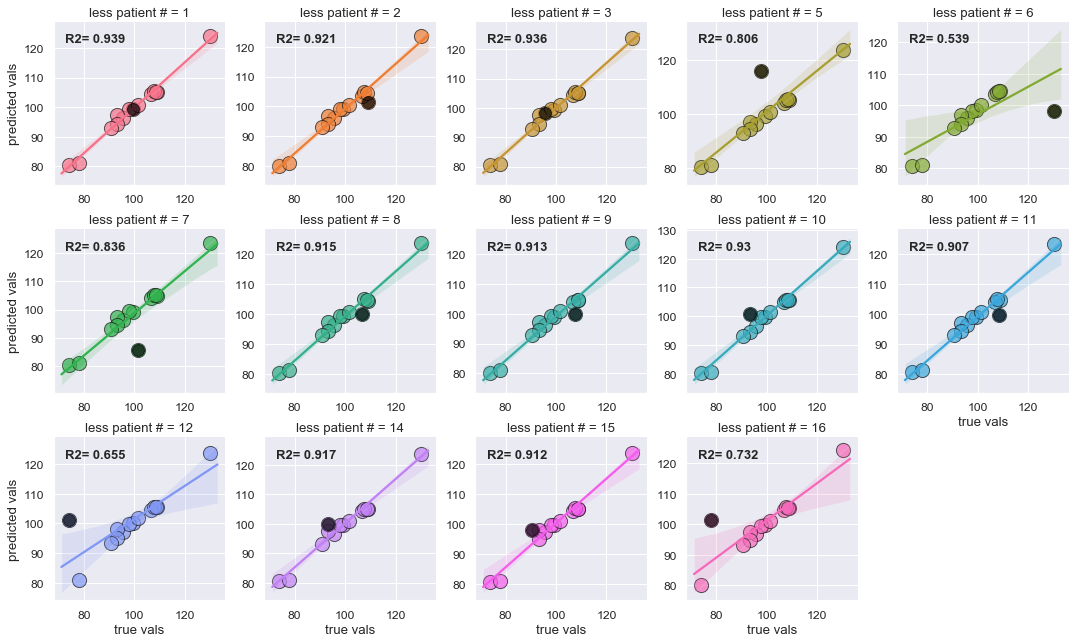

In [32]:
sns.set(font_scale=1.1)
plt.figure(figsize=(7,7))

ax = sns.lmplot(x='true vals', y='predicted vals', data=leave_one, 
                hue='less patient #', col='less patient #', 
                scatter_kws={'s':200, 'edgecolor':'k', 'facecolor':None, 'alpha':0.7}, height=3,
                sharey=False, sharex=False, col_wrap=5)

ax_list = ax.axes

for index, val in enumerate(list(leave_one['less patient #'].unique())):
    
    # pull out data for patient not present in training data
    parse_df = leave_one[leave_one['less patient #'] == val].copy()
    missing_patient = parse_df[parse_df['patient ids'] == val].copy()
    
    # color patient marker black
    ax_list[index].plot(missing_patient['true vals'], missing_patient['predicted vals'],
                        markersize=12, marker='o', mec='black', color='black', alpha=.7)
    
    # annotate coefficient of determination between predicted vs true vals
    r2_value = r2_score(parse_df['true vals'], parse_df['predicted vals'])
    text = AnchoredText(f'R2= {r2_value.round(3)}', loc='upper left', frameon=False, 
                        prop={'fontsize':13,'fontweight':'bold'})
    ax_list[index].add_artist(text)
    
plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/main figs/XGBoost leave one patient out performance telo means.png', 
            dpi=600, bbox_inches = "tight")

### Leave out two 

In [16]:
def correct_data(row):
    if row == 'less patient #[1 2]':
        return 'less patient #[1, 2]'
    else:
        return row
    
def return_real_ids_multiple(row):
    found = re.findall('(?<=#).*$', row)
    return literal_eval(found[0])

leave_two['less patient #'] = leave_two['less patient #'].apply(lambda row: correct_data(row))
leave_two['less patient #'] = leave_two['less patient #'].apply(lambda row: return_real_ids_multiple(row))
leave_two['hue col'] = leave_two['less patient #'].astype('str')
leave_two['hue col'] = leave_two['hue col'].astype('category')

<Figure size 504x504 with 0 Axes>

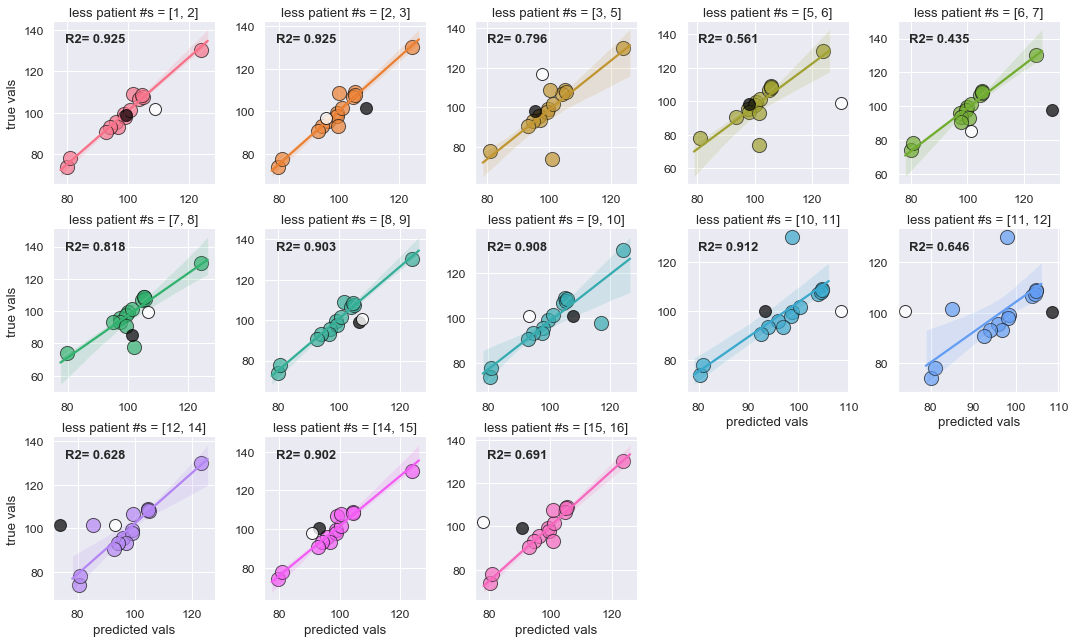

In [31]:
sns.set(font_scale=1.1)
plt.figure(figsize=(7,7))

ax = sns.lmplot(x='predicted vals', y='true vals', data=leave_two, 
                hue='hue col', col='hue col',
                scatter_kws={'s':200, 'edgecolor':'k', 'alpha':0.7}, height=3,
                sharey=False, sharex=False, col_wrap=5)

ax_list = ax.axes

for index, val in enumerate(list(leave_two['hue col'].unique())):

    # pull out data for patient(s) not present in training data
    parse_df = leave_two[leave_two['hue col'] == val].copy()
    val = literal_eval(val)
    missing_p1 = parse_df[parse_df['patient ids'] == val[0]].copy()
    
    # color patients missing from training data
    ax_list[index].plot(missing_p1['true vals'], missing_p1['predicted vals'],
                        markersize=12, marker='o', mec='black', color='black', alpha=.7)
    
    missing_p2 = parse_df[parse_df['patient ids'] == val[1]].copy()
    ax_list[index].plot(missing_p2['true vals'], missing_p2['predicted vals'],
                        markersize=12, marker='o', mec='black', color='white', alpha=.8)
    
    # annotate coefficient of determination for predicted vs true
    r2_value = r2_score(parse_df['true vals'], parse_df['predicted vals'])
    text = AnchoredText(f'R2= {r2_value.round(3)}', loc='upper left', frameon=False, 
                        prop={'fontsize':13,'fontweight':'bold'})
    ax_list[index].add_artist(text)
    
    ax_list[index].set_title(f'less patient #s = {val}')

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/main figs/XGBoost leave two patient out performance telo means.png', 
            dpi=600, bbox_inches = "tight")

### Leave out three 

In [21]:
def correct_data_thr(row):
    if row == 'less patient #[1 2 3]':
        return 'less patient #[1, 2, 3]'
    else:
        return row
    
def return_real_ids_multiple(row):
    found = re.findall('(?<=#).*$', row)
    return literal_eval(found[0])

leave_thr['less patient #'] = leave_thr['less patient #'].apply(lambda row: correct_data_thr(row))
leave_thr['less patient #'] = leave_thr['less patient #'].apply(lambda row: return_real_ids_multiple(row))
leave_thr['hue col'] = leave_thr['less patient #'].astype('str')
leave_thr['hue col'] = leave_thr['hue col'].astype('category')

<Figure size 504x504 with 0 Axes>

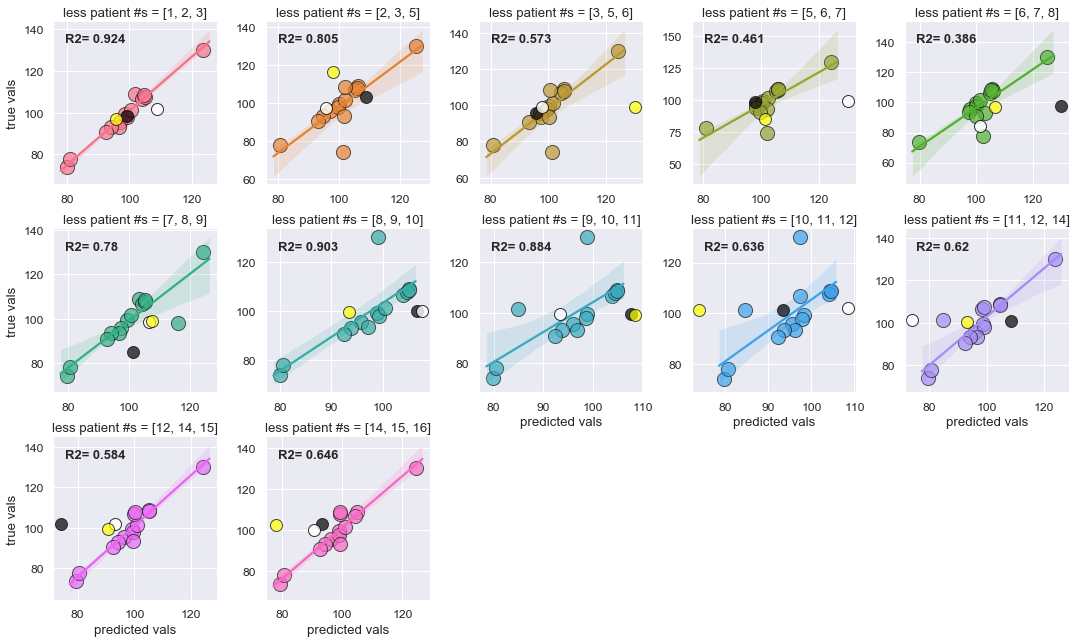

In [30]:
sns.set(font_scale=1.1)
plt.figure(figsize=(7,7))

ax = sns.lmplot(x='predicted vals', y='true vals', data=leave_thr, 
                hue='hue col', col='hue col',
                scatter_kws={'s':200, 'edgecolor':'k', 'alpha':0.7}, height=3,
                sharey=False, sharex=False, col_wrap=5)

ax_list = ax.axes

for index, val in enumerate(list(leave_thr['hue col'].unique())):

    # pull out data for patient(s) not present in training data
    parse_df = leave_thr[leave_thr['hue col'] == val].copy()
    
    # read patients IDs as list
    val = literal_eval(val)
    
    # identify patients that were missing from training data and color those patients 
    # on graph to emphasize XGBoost performance on patients not trained on
    missing_p1 = parse_df[parse_df['patient ids'] == val[0]].copy()
    ax_list[index].plot(missing_p1['true vals'], missing_p1['predicted vals'],
                        markersize=12, marker='o', mec='black', color='black', alpha=.7)
    
    missing_p2 = parse_df[parse_df['patient ids'] == val[1]].copy()
    ax_list[index].plot(missing_p2['true vals'], missing_p2['predicted vals'],
                        markersize=12, marker='o', mec='black', color='white', alpha=.8)
    
    missing_p3 = parse_df[parse_df['patient ids'] == val[2]].copy()
    ax_list[index].plot(missing_p3['true vals'], missing_p3['predicted vals'],
                        markersize=12, marker='o', mec='black', color='yellow', alpha=.7)
    
    # annotate coefficient of determination for predicted vs true
    r2_value = r2_score(parse_df['true vals'], parse_df['predicted vals'])
    text = AnchoredText(f'R2= {r2_value.round(3)}', loc='upper left', frameon=False, 
                        prop={'fontsize':13,'fontweight':'bold'})
    ax_list[index].add_artist(text)
    ax_list[index].set_title(f'less patient #s = {val}')

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/main figs/XGBoost leave three patient out performance telo means.png', 
            dpi=600, bbox_inches = "tight")

## Dataframe for model metrics

In [23]:
stats_df = trp.make_stats_df(stats_list=telo_row)

path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | features_individ telos.png'
trp.render_mpl_table(stats_df, col_width=6, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2037,0.0437,3.1995,0.8911,103040


## Testing if linear regression can predict 4C mean telos using individual telos

In [ ]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [ ]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

In [ ]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

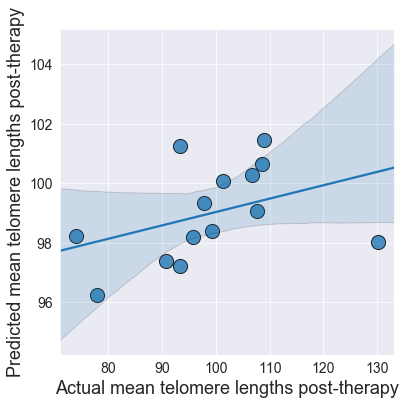

In [26]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [23]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [24]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      pred_obj='4 C # short telos from individual telos')

In [91]:
# # saving view of preprocessed data
# example = quartile_telo_data.copy()
# example.rename({'timepoint':'pre-therapy sample origin', 
#                 'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)
# example_8 = example[10:16].reset_index(drop=True)
# path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length SHORT TELOS dataframe.png'
# trp.render_mpl_table(example_8, col_width=4, path=path)

## Train/test split 

In [7]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [8]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [41]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=1,)
q_xgb_pipe = Pipeline([('XGB', q_model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [20]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

In [21]:
# saving view of post-processed data
# example8 = q_train_clean[['timepoint_2 irrad @ 4 Gy', 
#                                        'individual telomeres', 
#                                        '4 C # short telos']].copy()
# example = example8.copy()
# example.rename({'timepoint_2 irrad @ 4 Gy':'encoded sample origin', 
#                 'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)

# example_8 = example[10:16].reset_index(drop=True)

# path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length SHORT TELOS dataframe.png'
# trp.render_mpl_table(example_8, col_width=4, path=path)

## Visualizing model objective

In [228]:
# q_train_set.sort_values(by='patient id', ascending=True, inplace=True)
# q_train_set.reset_index(drop=True, inplace=True)
# temp = q_train_set.copy()
# temp['4 C # short telos'] = temp['4 C # short telos'] / 10

# trp.plot_individ_telos_ML_objective(df=temp, target='4 C # short telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [42]:
q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean, 
                                                             test_set=q_test_clean, model=q_model, 
                                                             cv=5, target='4 C # short telos',
                                                             verbose=True)

MAE per CV fold: 
[233.66749225 238.82093177 228.95524709 234.77619031 234.8047745 ] 

MEAN of MAE all folds: 234.20492718456694
STD of MAE all folds: 3.157265720620643

MAE of predict_y_test & y_test: 234.17443956943774
R2 between predict_y_test & y_test: 0.8112421077788301


In [23]:
# evaluating model based on N samples in training data
short_telos_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean.sample(n), 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)
    short_telos_row[0].append(n)
    short_telos_model_df += (short_telos_row)

In [24]:
q_model_metrics_n_train = pd.DataFrame(short_telos_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])

q_model_metrics_n_train['Features'] = q_model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
q_model_metrics_n_train['Features'] = 'individual telos, encoded samples'
q_model_metrics_n_train.drop(['Model', 'Features', 'Target'], axis=1, inplace=True)

In [25]:
# display(q_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number short telos | per N training samples 100 to 100000.png'
trp.render_mpl_table(q_model_metrics_n_train, col_width=4, path=path)

In [26]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 212.4232221330915
R2 predicted vs. actual 4 C # short telos: 0.8683566050253889


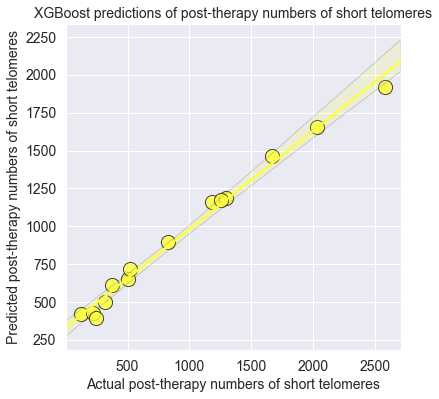

In [265]:
sns.set_color_codes()

plt.figure(figsize=(6,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, color='#fdff38')
ax.set_xlabel("Actual post-therapy numbers of short telomeres", fontsize=14)
ax.set_ylabel("Predicted post-therapy numbers of short telomeres", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy numbers of short telomeres', fontsize=14, )
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # short telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [283]:
telo_row[0].append(103040)
short_telos_row[0].append(103040)

telos_short_telos_rows = telo_row + short_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2051,0.0565,3.2038,0.8874,103040
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,235.9586,1.9788,231.9450,0.8164,103040


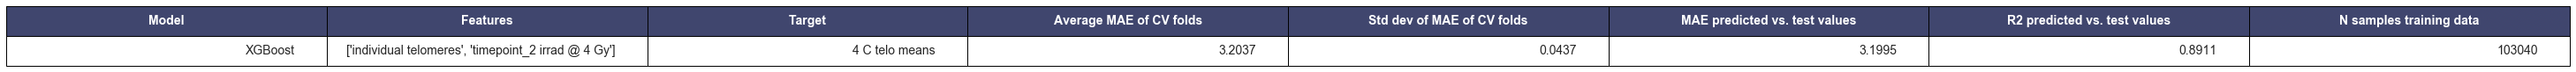

In [37]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 # short telos.png'
trp.render_mpl_table(stats_df, col_width=6.5, path=path)

# Machine Learning - exploring predictions of #s of long telomeres post-therapy

## Loading/merging data for ML

In [58]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [59]:
long_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      pred_obj='4 C # long telos from individual telos')

In [88]:
# saving view of preprocessed data
example = long_telo_data.copy()
example.rename({'timepoint':'pre-therapy sample origin', 
                'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)
example_8 = example[10:16].reset_index(drop=True)
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length LONG TELOS dataframe.png'
trp.render_mpl_table(example_8, col_width=4, path=path)

## Train/test split 

In [60]:
long_telo_test = long_telo_data.copy()

y = long_telo_test[['4 C # long telos']]
X = long_telo_test.drop(['4 C # long telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

long_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
long_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [61]:
long_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [62]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
long_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=1, )

long_xgb_pipe = Pipeline([('XGB', long_model)
                      ])

long_full_pipe = Pipeline([('clean_process', long_clean_process_pipe),
                        ('model', long_model)
                       ])

## Cleaning/modeling data with pipeline

In [63]:
long_train_clean = long_train_set.copy()
long_test_clean = long_test_set.copy()

long_train_clean = long_clean_process_pipe.fit_transform(long_train_clean)
long_test_clean = long_clean_process_pipe.fit_transform(long_test_clean)

In [87]:
# saving view of post-processed data
example = long_train_clean[['timepoint_2 irrad @ 4 Gy', 
                                       'individual telomeres', 
                                       '4 C # long telos']].copy()

example.rename({'timepoint_2 irrad @ 4 Gy':'encoded sample origin', 
                'individual telomeres':'individual telomeres (RFI)'}, axis=1, inplace=True)

example_8 = example[10:16].reset_index(drop=True)

path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length LONG TELOS dataframe.png'
trp.render_mpl_table(example_8, col_width=4, path=path)

## Visualizing model objective

In [298]:
# long_train_set.sort_values(by='patient id', ascending=True, inplace=True)
# long_train_set.reset_index(drop=True, inplace=True)
# temp = long_train_set.copy()
# temp['4 C # long telos'] = temp['4 C # long telos'] / 20

# trp.plot_individ_telos_ML_objective(df=temp, target='4 C # long telos')

## Cross validation; MAE & R2 score when predicting # of long telomeres post-therapy (4 C)

In [48]:
long_fit_xgb_model, long_telos_row = trp.cv_score_fit_mae_test(train_set=long_train_clean, 
                                                                 test_set=long_test_clean, model=long_model, 
                                                                 cv=5, target='4 C # long telos',
                                                                 verbose=True)

MAE per CV fold: 
[333.06073075 323.97976701 325.24759862 326.06297065 327.66984242] 

MEAN of MAE all folds: 327.20418188912527
STD of MAE all folds: 3.16365095365997

MAE of predict_y_test & y_test: 331.8494495581396
R2 between predict_y_test & y_test: 0.8229788216640934


In [64]:
# evaluating model based on N samples in training data
long_telos_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    long_fit_xgb_model, long_telos_row = trp.cv_score_fit_mae_test(train_set=long_train_clean.sample(n), 
                                                                 test_set=long_test_clean, model=long_model, 
                                                                 cv=5, target='4 C # long telos',
                                                                 verbose=False)
    long_telos_row[0].append(n)
    long_telos_model_df += (long_telos_row)

In [65]:
long_model_metrics_n_train = pd.DataFrame(long_telos_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])

long_model_metrics_n_train['Features'] = long_model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))
long_model_metrics_n_train['Features'] = 'individual telos, encoded samples'
long_model_metrics_n_train.drop(['Model', 'Features', 'Target'], axis=1, inplace=True)

In [66]:
# display(long_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number long telos | per N training samples 100 to 100000.png'
trp.render_mpl_table(long_model_metrics_n_train, col_width=4, path=path)

In [67]:
long_y_xgb_predict, long_y_true = trp.predict_target_4C_compare_actual(telo_data=long_telo_data, test_set=long_test_set, 
                                                                 model=long_fit_xgb_model, target='4 C # long telos',
                                                                 clean_process_pipe=long_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # long telos: 293.9542715890067
R2 predicted vs. actual 4 C # long telos: 0.8839268631681945


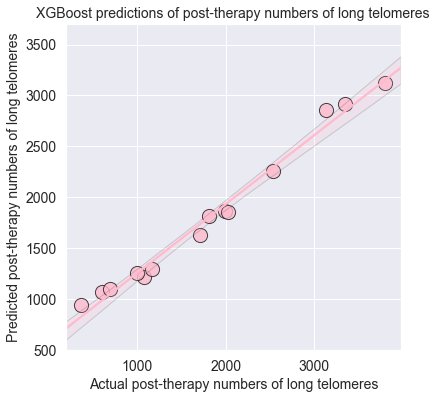

In [306]:
sns.set_color_codes()

plt.figure(figsize=(6,6))
ax = sns.regplot(x=long_y_true, y=long_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, color='#ffbacd')
ax.set_xlabel("Actual post-therapy numbers of long telomeres", fontsize=14)
ax.set_ylabel("Predicted post-therapy numbers of long telomeres", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy numbers of long telomeres', fontsize=14, )
plt.ylim(500, 3700)
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # long telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [307]:
telos_short_telos_rows = telo_row + short_telos_row + long_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2051,0.0565,3.2038,0.8874,103040
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,235.9586,1.9788,231.9450,0.8164,103040
2,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # long telos,324.8429,3.0600,328.4998,0.8232,103040


In [308]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 short telos and #3 long telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [42]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [10]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [183]:
# # testing if adding 1 to every observation/CA enhances ML.. (it doesn't)

# chr_train = chr_train.copy()
# for col in chr_train.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_train[col] = chr_train[col] + 1
# #         chr_train[col] = np.log10(chr_train[col])
        
# chr_test = chr_test.copy()
# for col in chr_test.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_test[col] = chr_test[col] + 1
# #         chr_test[col] = np.log10(chr_test[col])

## Initializing cleaning/model pipelines

In [11]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [12]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

In [40]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [60]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.11672691 0.19840033 0.1643636  0.20224092 0.20403181] 

MEAN of MAE all folds: 0.17715271292656237
STD of MAE all folds: 0.03352075492010987

MAE of predict_y_test & y_test: 0.2753826078204882
R2 between predict_y_test & y_test: -0.02409218979297223


In [61]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

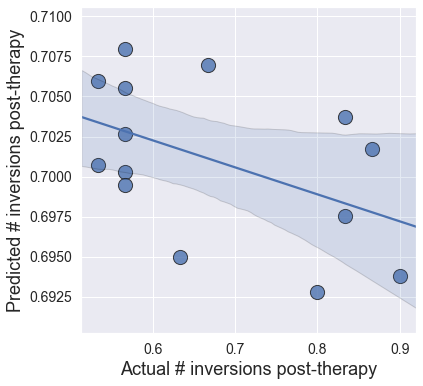

In [156]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=18)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)

## Looping through all chr aberration types for XGBoost model fitting, creating dict for graphing & list for displaying model metrics

In [37]:
features_list = [['# inversions'], ['# translocations'], 
                 ['# dicentrics'], ['# excess chr fragments'],
                 ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']]

           
target1_list = ['# inversions', '# translocations', 
                '# dicentrics', '# excess chr fragments',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # translocations', 
                '4 C # dicentrics', '4 C # excess chr fragments',
                '4 C aberration index']

stats_list = []
stats_list, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                    target1_list=target1_list,
                                                                                    target2_list=target2_list,
                                                                                    stats_list=stats_list,
                                                                                    verbose=False)

## Displaying model metrics in dataframe & graphing performance

In [38]:
import copy

stats_list_copy = copy.deepcopy(stats_list)
n_rows = cleaned_chr_train.shape[0]

for row in stats_list_copy:
    row.append(n_rows)

In [39]:
# saving df of model metrics for chr aberr models

graphing_df = trp.make_graphing_df(graphing_dict=graphing_dict)
stats_df = trp.make_stats_df(stats_list=stats_list_copy)
stats_df['Features'] = stats_df['Features'].apply(lambda row: ', '.join(row))

stats_df.iloc[0, 1] = '# inversions, encoded samples'
stats_df.iloc[1, 1] = '# translocations, encoded samples'
stats_df.iloc[2, 1] = '# dicentrics, encoded samples'
stats_df.iloc[3, 1] = '# excess chr fragments, encoded samples'
stats_df.iloc[4, 1] = 'all aberrations, encoded samples'
stats_df.drop(['Model', 'N samples training data'], axis=1, inplace=True)

path=f'../graphs/paper figures/supp figs/1 ML models metrics for all chr aberration types.png'
trp.render_mpl_table(stats_df, col_width=5.3, path=path)

In [31]:
# saving df of model metrics for all models
# all_rows = telo_row + short_telos_row + stats_list_copy
# stats_df = trp.make_stats_df(stats_list=all_rows)

# path=f'../graphs/paper figures/supp figs/ML model metrics for all telo and chr aberr endpoints.png'
# trp.df_to_png(df=stats_df, path=path)

In [161]:
graphing_df.rename({'predicted values':'Predicted values',
                    'actual values':'Actual values'}, axis=1, inplace=True)

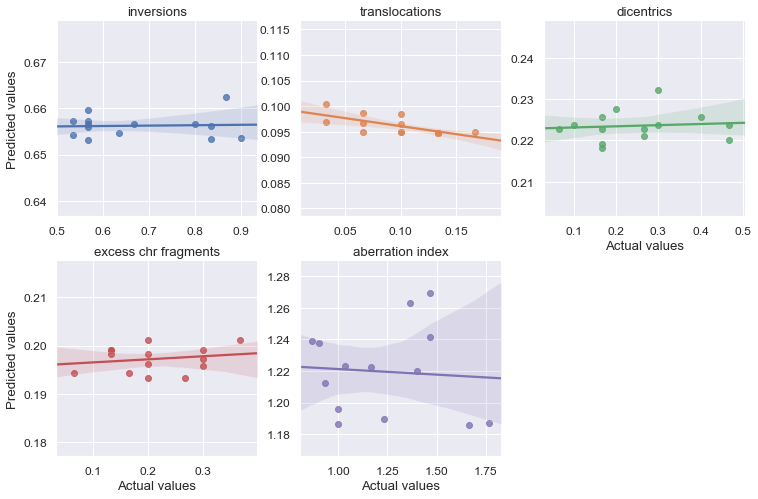

In [163]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='Actual values', y='Predicted values', col='aberration type', hue='aberration type',
                col_order=['# inversions', '# translocations', 
                           '# dicentrics', '# excess chr fragments', 'aberration index'],
                sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.5)

ax_list = ax.axes
ax_list[0].set_title('inversions')
ax_list[1].set_title('translocations')
ax_list[2].set_title('dicentrics')
ax_list[3].set_title('excess chr fragments')
ax_list[4].set_title('aberration index')

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/supp figs/ML models performance for all chr aberr types.png',
            dpi=400, bbox_iches='tight')

## Making dataframes showing chr aberr data setup

In [43]:
features = ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']
target = 'aberration index'

# features = ['# inversions']
# target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [44]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [45]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

In [23]:
# aberration index

test_viz_post = cleaned_chr_train[['timepoint_2 irrad @ 4 Gy', '# inversions', '# translocations', 
                                   '# dicentrics', '# excess chr fragments', '4 C aberration index']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions', '# translocations', 
                          '# dicentrics', '# excess chr fragments',]]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C aberration index']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

test_viz_PRE.rename({'timepoint':'pre-therapy sample origin'}, axis=1, inplace=True)
test_viz_post.rename({'timepoint_2 irrad @ 4 Gy':'encoded sample origin'}, axis=1, inplace=True)

path=f'../graphs/paper figures/supp figs/example view ALL chr aberr PRE CLEAN dataframe for ML.png'
trp.render_mpl_table(test_viz_PRE.sample(6).reset_index(drop=True), col_width=3.2, path=path)
path=f'../graphs/paper figures/supp figs/example view ALL chr aberr POST CLEAN dataframe for ML.png'
trp.render_mpl_table(test_viz_post.sample(6).reset_index(drop=True), col_width=3.2, path=path)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# inversions

test_viz_post = cleaned_chr_train[['timepoint_2 irrad @ 4 Gy', '# inversions', 
                                   '4 C # inversions']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions']]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C # inversions']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

test_viz_PRE.rename({'timepoint':'pre-therapy sample origin'}, axis=1, inplace=True)
test_viz_post.rename({'timepoint_2 irrad @ 4 Gy':'encoded sample origin'}, axis=1, inplace=True)

path=f'../graphs/paper figures/supp figs/example view INVERSIONS PRE CLEAN chr aberr dataframe for ML.png'
trp.render_mpl_table(test_viz_PRE.sample(6).reset_index(drop=True), col_width=3.2, path=path)
path=f'../graphs/paper figures/supp figs/example view INVERSIONS POST CLEAN chr aberr dataframe for ML.png'
trp.render_mpl_table(test_viz_post.sample(6).reset_index(drop=True), col_width=3.2, path=path)

# Clustering telomere data

## Mean telomere length (teloFISH)

In [11]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)

In [12]:
means.head(4)

,patient id,timepoint,telo means
0,1,1 non irrad,84.796483
1,1,2 irrad @ 4 Gy,90.975826
2,1,3 B,116.779989
3,1,4 C,99.346299


In [7]:
pivot = means.pivot_table(index=['patient id'], columns='timepoint', values='telo means').reset_index()
pivot.columns.name = ''

pivot = pivot[pivot['patient id'] != 13].copy()
pivot.set_index(pivot['patient id'], inplace=True)
pivot.drop(['patient id'], axis=1, inplace=True)

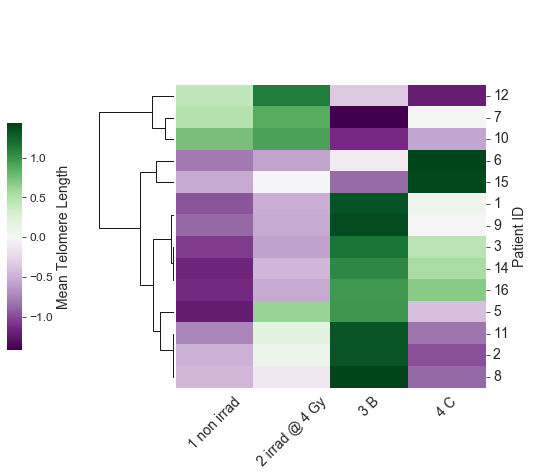

In [463]:
g = sns.clustermap(pivot, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Mean Telomere Length', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [14]:
means.head(4)

,patient id,timepoint,telo means
0,1,1 non irrad,84.796483
1,1,2 irrad @ 4 Gy,90.975826
2,1,3 B,116.779989
3,1,4 C,99.346299


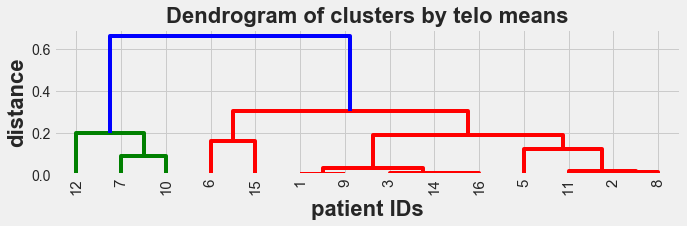

,clusters,patient id,1,2,3,4
0,2,1,84.796483,90.975826,116.779989,99.346299
1,2,2,119.773675,133.199443,159.827558,108.915327
2,2,3,83.350928,87.295453,101.432564,95.669501
3,2,5,85.506106,113.095980,118.340459,97.832190
4,2,6,81.577970,86.403786,96.898929,130.118940
5,1,7,106.123851,110.051355,85.958697,101.402469
6,2,8,110.560114,113.514599,127.614062,106.652869
7,2,9,94.452253,99.629321,128.528917,107.674947
8,1,10,120.920889,124.741261,81.237654,93.352253
9,2,11,109.637490,122.192509,137.957127,108.571714


0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


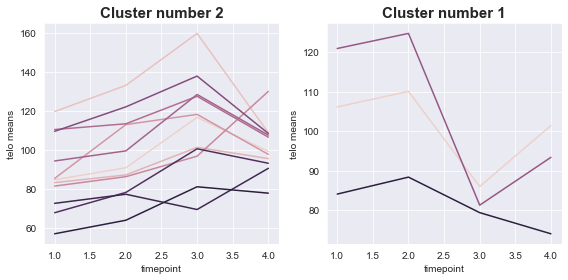

In [18]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             x_size=8, y_size=4)

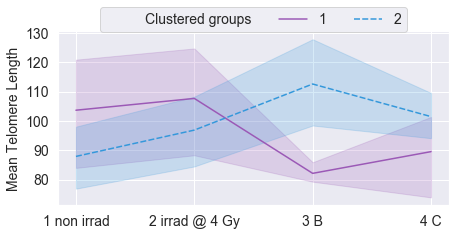

In [340]:
clustered_graphing = clustered_telos.rename({'telo means cluster groups': 'Clustered groups'}, axis=1).copy()

trp.graph_cluster_groups(clustered_graphing, target='telo means', hue='Clustered groups')

In [235]:
df = clustered_graphing[clustered_graphing['Clustered groups'] == 1] 

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.04395417105675324
      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper  reject
--------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  4.0158  -34.9883 43.0199 False 
 1 non irrad        3 B       -21.5157 -60.5198 17.4884 False 
 1 non irrad        4 C       -14.1147 -53.1189 24.8894 False 
2 irrad @ 4 Gy      3 B       -25.5315 -64.5356 13.4726 False 
2 irrad @ 4 Gy      4 C       -18.1306 -57.1347 20.8736 False 
     3 B            4 C        7.401   -31.6032 46.4051 False 
--------------------------------------------------------------


telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


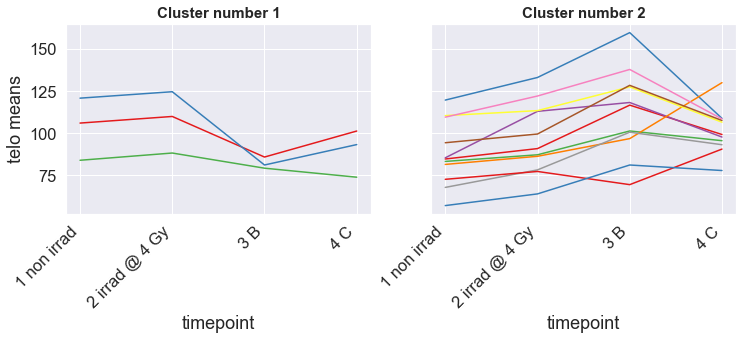

In [25]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [325]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': 'Number of short telomeres'}, inplace=True)

In [326]:
pivot1 = short_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of short telomeres').reset_index()
pivot1.columns.name = ''

pivot1 = pivot1[pivot1['patient id'] != 13].copy()
pivot1.set_index(pivot1['patient id'], inplace=True)
pivot1.drop(['patient id'], axis=1, inplace=True)

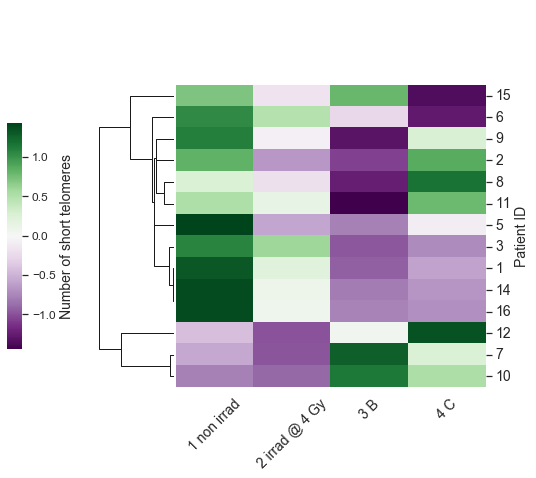

In [327]:
g = sns.clustermap(pivot1, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Number of short telomeres', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

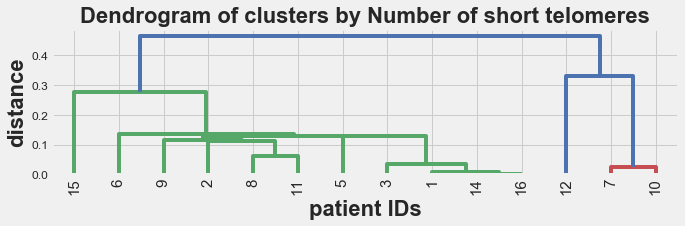

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


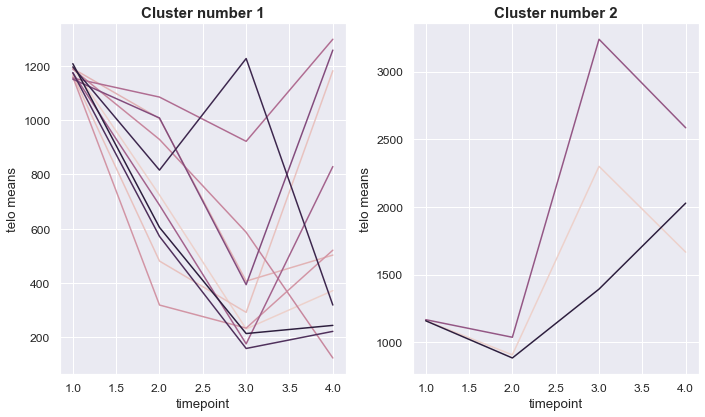

In [328]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='Number of short telomeres', cut_off_n=2)

In [329]:
clustered_short_telos['Clustered groups'] = (clustered_short_telos['Number of short telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

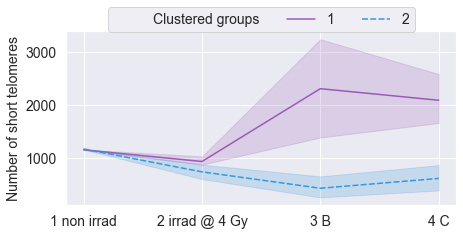

In [332]:
trp.graph_cluster_groups(clustered_short_telos, target='Number of short telomeres', hue='Clustered groups')

# short telomeres CLUSTER 1 | patient IDs: [7, 10, 12]
# short telomeres CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


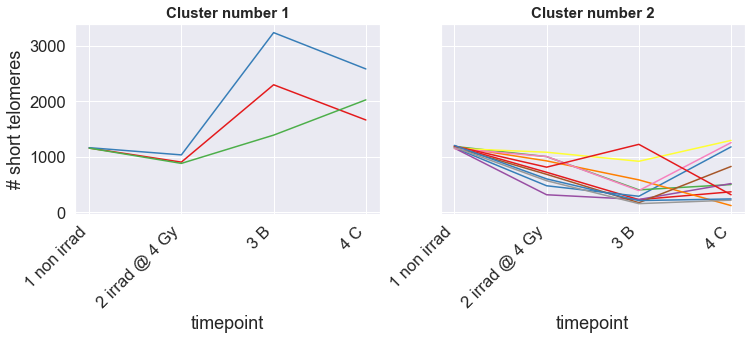

In [31]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Combining cluster groups of means + short telos

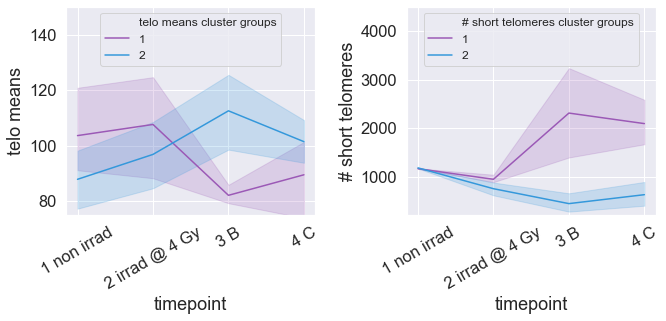

In [33]:
y_list = ['telo means', '# short telomeres']
hue_list = ['telo means cluster groups', '# short telomeres cluster groups']
df_list = [clustered_telos, clustered_short_telos]
ylim_dict = {'telo means': (75, 150),
             '# short telomeres': (200, 4500)}

trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

## Long telomeres

In [310]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
long_telos = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'telo means'], axis=1)
long_telos.rename(columns={'Q4': 'Number of long telomeres'}, inplace=True)

In [312]:
pivot2 = long_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of long telomeres').reset_index()
pivot2.columns.name = ''

pivot2 = pivot2[pivot2['patient id'] != 13].copy()
pivot2.set_index(pivot2['patient id'], inplace=True)
pivot2.drop(['patient id'], axis=1, inplace=True)

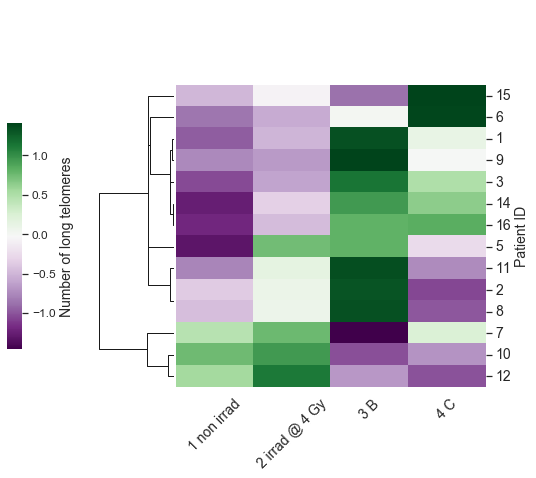

In [313]:
g = sns.clustermap(pivot2, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Number of long telomeres', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by long telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

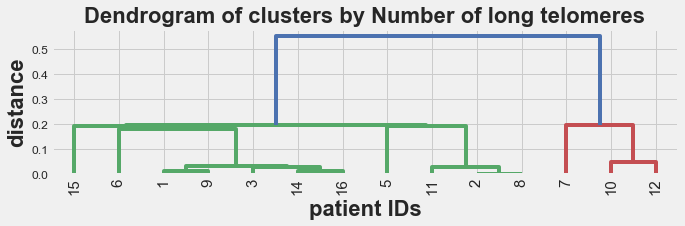

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


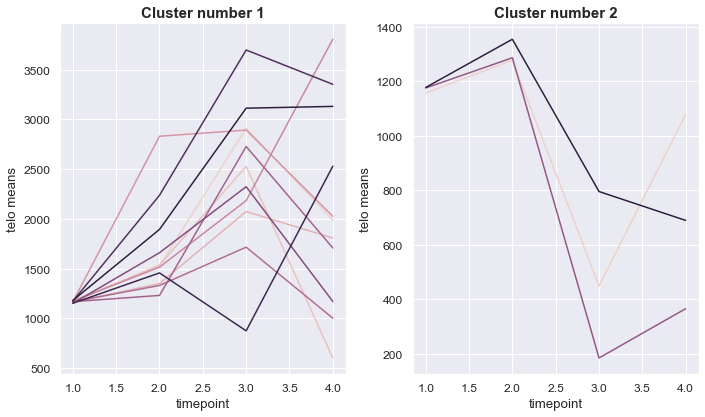

In [314]:
clustered_long_telos = trp.cluster_data_return_df(long_telos, target='Number of long telomeres', cut_off_n=2)

In [317]:
clustered_long_telos['Clustered groups'] = (clustered_long_telos['Number of long telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

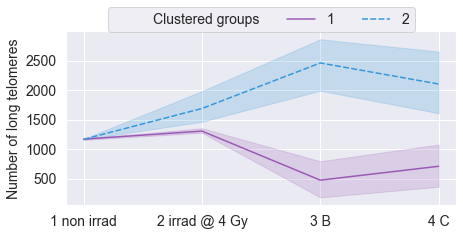

In [342]:
trp.graph_cluster_groups(clustered_long_telos, target='Number of long telomeres', hue='Clustered groups')

Number of long telomeres CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]
Number of long telomeres CLUSTER 2 | patient IDs: [7, 10, 12]


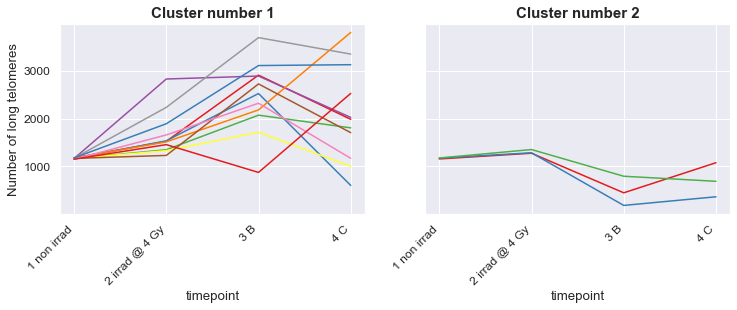

In [322]:
trp.graph_clusters_per_patient(clustered_long_telos, target='Number of long telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

# Clustering chromosome rearrangement data

In [36]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False)),
                            ('features', trp.make_chr_features(combine_inversions=True))
                           ])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

In [37]:
mean_chr.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333
1,1,2 irrad @ 4 Gy,0.766667,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333
2,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000
3,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333
4,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333


## Testing cluster functions on inversions / excess chr fragments

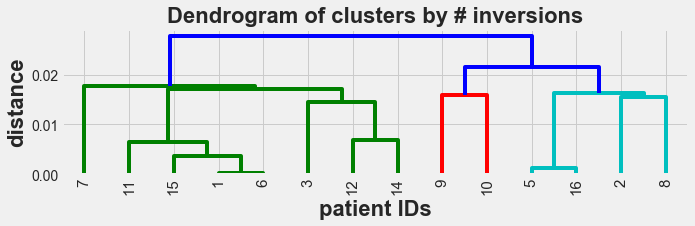

0 Cluster number 1 has 8 elements
1 Cluster number 2 has 6 elements


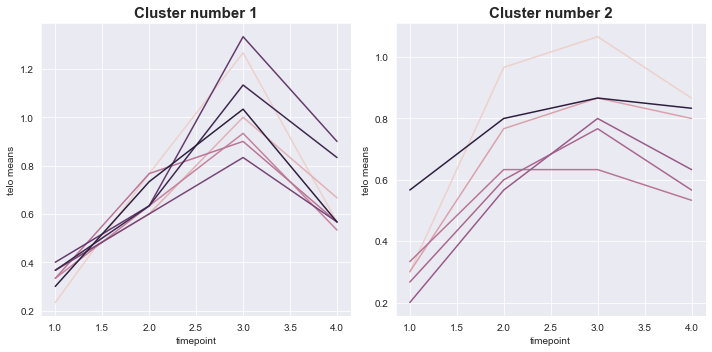

In [38]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

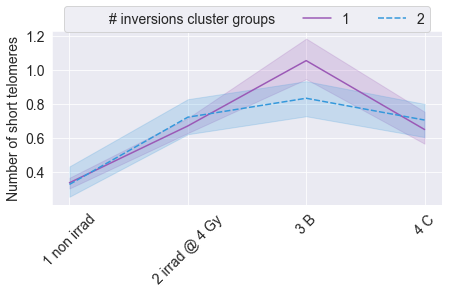

In [39]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 3, 6, 7, 11, 12, 14, 15]
# inversions CLUSTER 2 | patient IDs: [2, 5, 8, 9, 10, 16]


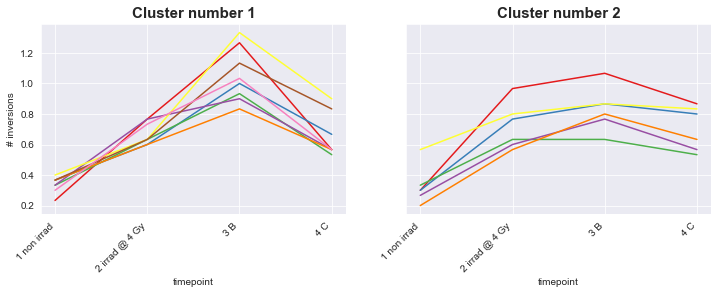

In [40]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions', y_dimen=1, x_dimen=2, fsize=(12,3.5))

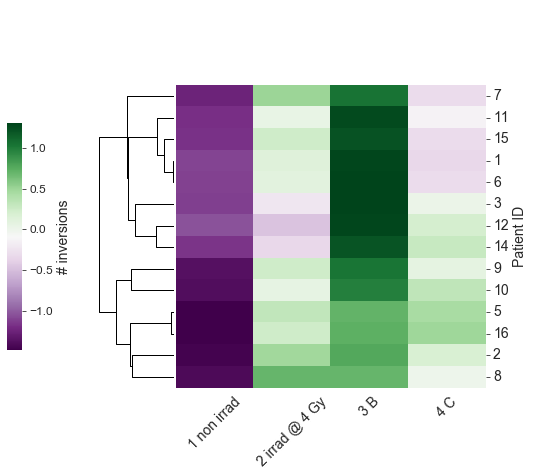

In [41]:
trp.make_clustered_heatmap(df=mean_chr, target='# inversions', cb_target_label='# inversions')

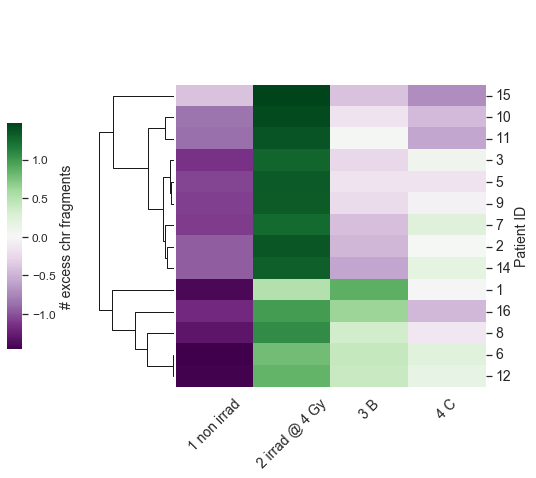

In [609]:
trp.make_clustered_heatmap(df=mean_chr, target='# excess chr fragments', cb_target_label='# excess chr fragments')

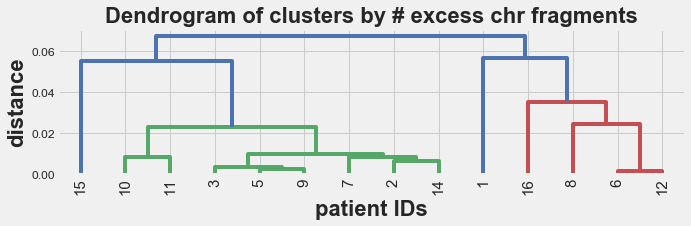

0 Cluster number 2 has 5 elements
1 Cluster number 1 has 9 elements
# excess chr fragments CLUSTER 1 | patient IDs: [2, 3, 5, 7, 9, 10, 11, 14, 15]
# excess chr fragments CLUSTER 2 | patient IDs: [1, 6, 8, 12, 16]


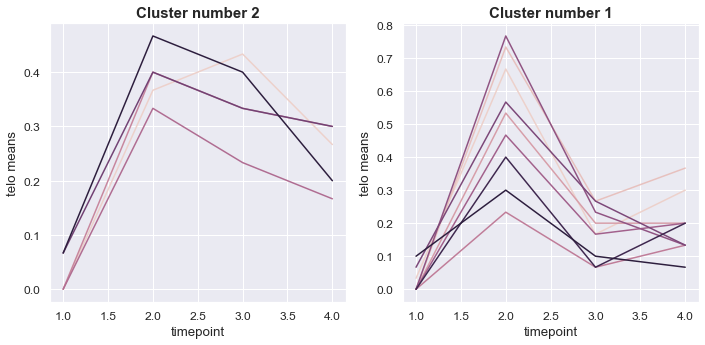

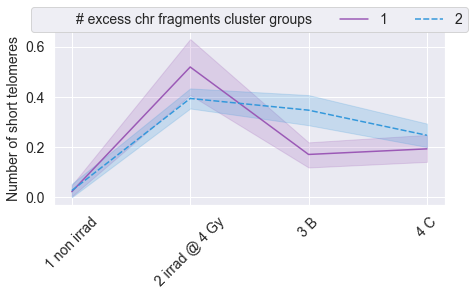

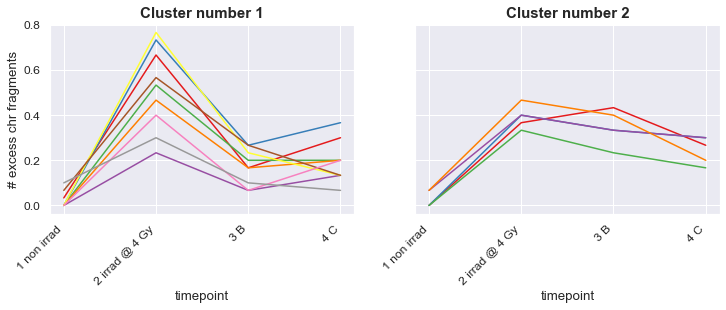

In [508]:
target = '# excess chr fragments'

clustered_invs = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=2, y_size=5, x_size=10)
trp.graph_cluster_groups(clustered_invs, target=target, hue=f'{target} cluster groups')
trp.graph_clusters_per_patient(clustered_invs, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Looping through all clustered groups graphs

In [71]:
# chr_aberr = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']

# for target in chr_aberr:
#     if target == '# inversions':
#         n = 2
#     else:
#         n = 1
#     clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=n)
#     trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
#     trp.graph_clusters_per_patient(clustered, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Graphing all aberration cluster groups at once

In [42]:
mean_chr['aberration index'] = (mean_chr['# inversions'] + mean_chr['# translocations'] + 
                                mean_chr['# dicentrics'] + mean_chr['# excess chr fragments'])

In [43]:
mean_chr.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations,aberration index
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333,0.266667
1,1,2 irrad @ 4 Gy,0.766667,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333,1.666667
2,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000,2.166667
3,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333,1.033333
4,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333,0.366667


In [54]:
# initializing list of aberrations to cluster by
y_list = ['# inversions', 
          '# translocations', 
          '# dicentrics',
          '# excess chr fragments',
          'aberration index']

# initializing list of dfs bearing clustered groups
inv_df = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2, verbose=False)
trans_df = trp.cluster_data_return_df(mean_chr, target='# translocations', cut_off_n=1, verbose=False)
dicent_df = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1, verbose=False)
chr_frag_df = trp.cluster_data_return_df(mean_chr, target='# excess chr fragments', cut_off_n=2, verbose=False)
aberr_index_df = trp.cluster_data_return_df(mean_chr, target='aberration index', cut_off_n=1, verbose=False)

df_list = [inv_df,
           trans_df, 
           dicent_df,
           chr_frag_df,
           aberr_index_df]

# hues to graph by
hue_list = ['# inversions cluster groups',
            '# translocations cluster groups', 
            '# dicentrics cluster groups',
            '# excess chr fragments cluster groups',
            'aberration index cluster groups']

# dimensions for each aberration
ylim_dict = {'# inversions': (.1, 1.7),
             '# translocations': (0, .4),
             '# dicentrics': (0, 1),
             '# excess chr fragments': (0, .95),
             'aberration index': (.2, 3)}

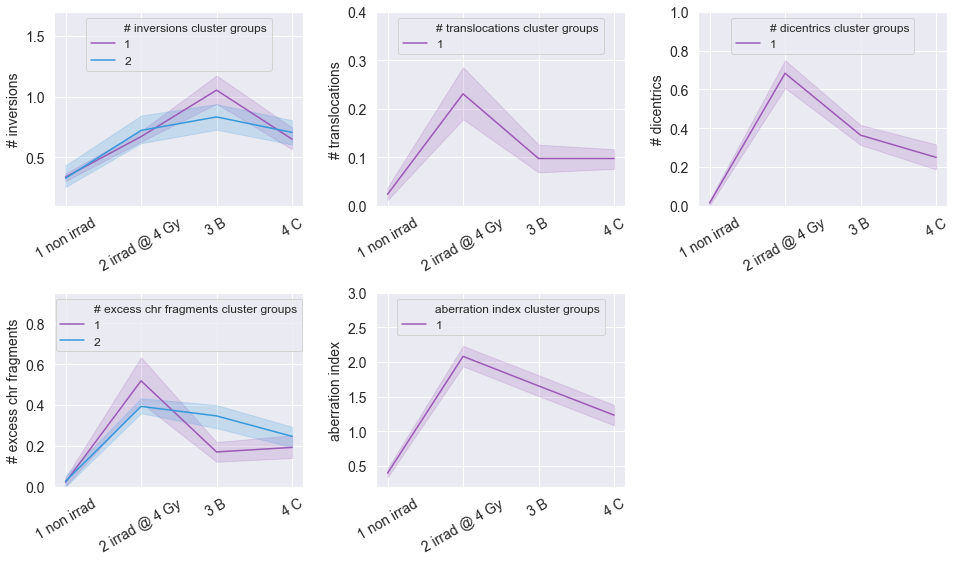

In [58]:
trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

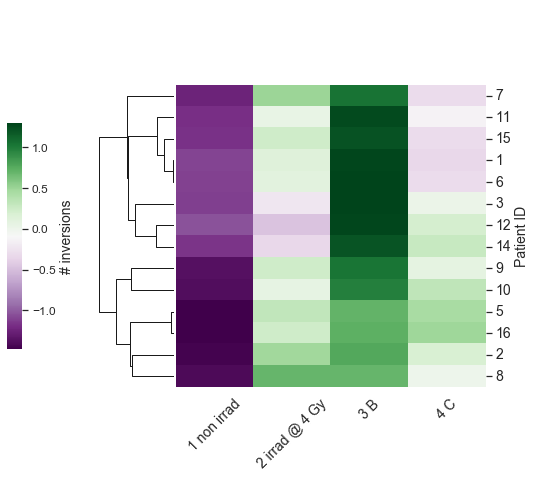

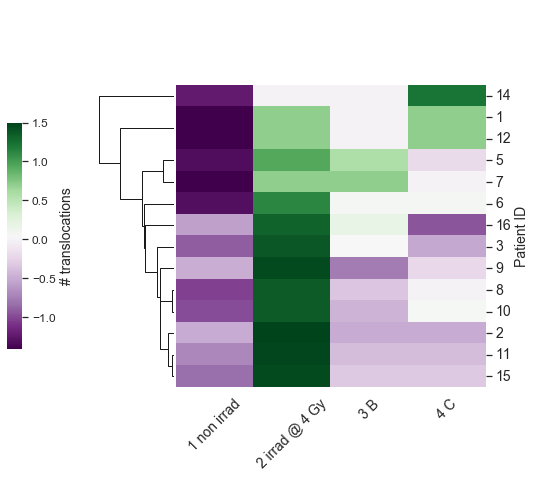

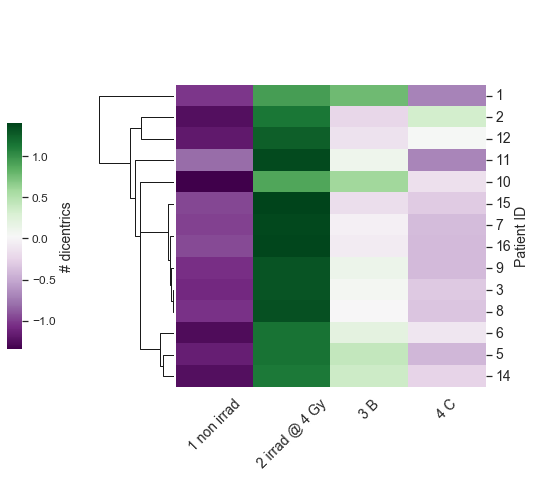

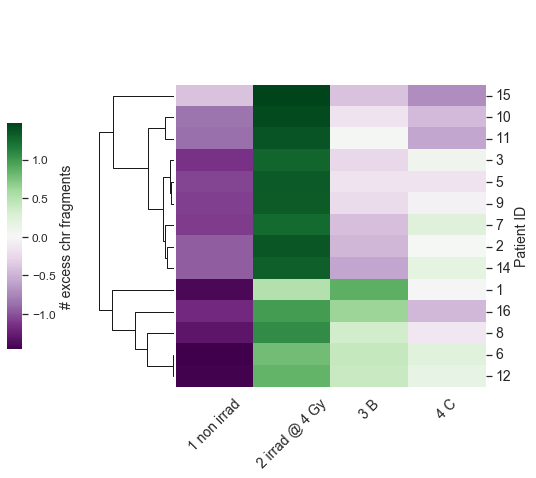

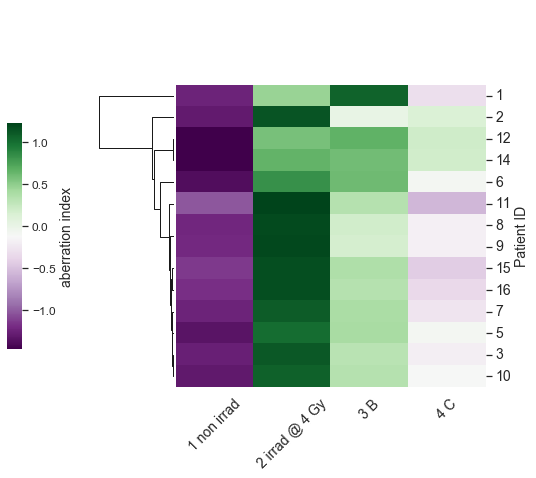

In [59]:
aberr_list = ['# inversions', '# translocations', 
              '# dicentrics', '# excess chr fragments', 'aberration index']

for aberr in aberr_list:
    trp.make_clustered_heatmap(df=mean_chr, target=aberr, cb_target_label=aberr)

# Exploratory analysis of telomere data and chromosome aberrations

In [254]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [255]:
combined = all_patients_df.merge(cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean'), on=['patient id', 'timepoint'])
combined.head(4)

,patient id,timepoint,telo data,telo means,Q1,Q2-3,Q4,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,"[79.18994405924711, 58.07204491719145, 95.0279...",84.796483,1195,2225,1180,0.066667,0.166667,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333
1,1,2 irrad @ 4 Gy,"[149.93296075217452, 138.31843562348496, 106.6...",90.975826,724,2350,1526,0.466667,0.300000,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333
2,1,3 B,"[176.32960877192357, 111.92066838585988, 123.5...",116.779989,231,1457,2912,0.800000,0.466667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000
3,1,4 C,"[144.65363114822472, 84.46927366319692, 78.133...",99.346299,372,2241,1987,0.300000,0.266667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333


In [256]:
import umap

In [257]:
combined['total inversions'] = combined['# inversions'] + combined['# terminal inversions']

parsed = combined[['patient id', 'timepoint', 'telo means', 
                   'total inversions', '# dicentrics', 
                   '# excess chr fragments', '# translocations']].copy()

parsed['telo means'] = parsed['telo means'] / parsed['telo means'].mean()

def encode_row(row):
    time_dict = {'1 non irrad':1,
                 '2 irrad @ 4 Gy':2,
                 '3 B':3,
                 '4 C':4}
    return time_dict[row]

target = parsed[['patient id', 'timepoint']].copy()
parsed['timepoint'] = parsed['timepoint'].apply(lambda row: encode_row(row))
features = parsed.drop(['patient id', 'timepoint'], axis=1)

In [264]:
#UMAP DIMENSIONALITY REDUCTION
reducer = umap.UMAP(random_state=36, metric='manhattan', n_neighbors=15)
embeddings = reducer.fit_transform(features)

# RECOMBINING ASTRO ID/FLIGHT STATUS W/ UMAP VECTORS
embed = pd.DataFrame(embeddings, columns=['dim1', 'dim2'])
embed = pd.concat([embed, target], axis=1)

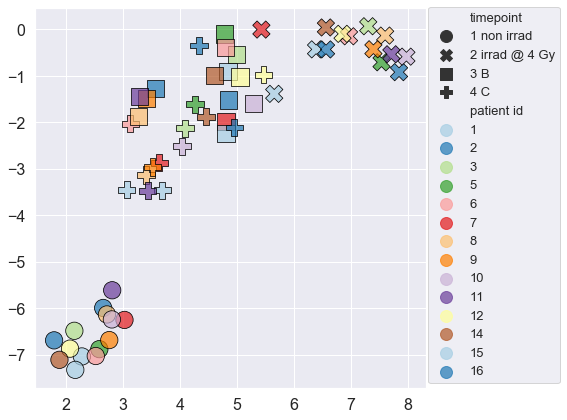

In [266]:
fontsize=16

plt.figure(figsize=(7,7))
# embed.rename({'astro id':'Astro ID', 'flight status':'Flight status'}, axis=1, inplace=True)

colors = sns.color_palette('Paired', len(embed['patient id'].unique())), 
t = (0.7,)
test = [x + t for x in colors[0]]

ax = sns.scatterplot(x='dim1', y='dim2', data=embed, 
                     hue='patient id', 
                     style_order=['1 non irrad', '2 irrad @ 4 Gy', '3 B', '4 C'],
                     alpha=None, style='timepoint', legend='full',
#                      palette=sns.color_palette('Paired', len(embed['patient id'].unique())), 
                     palette=test,  

                    **{'s':300, 'linewidths':1, 'edgecolor':'black'})

plt.tick_params(labelsize=fontsize)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('', fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[15:]+handles[0:15], labels[15:]+labels[0:15],
           loc='upper left', bbox_to_anchor=(.99, 1.02),
           fancybox=True, markerscale=2, fontsize=13)

plt.savefig(f'../graphs/paper figures/main figs/UMAP unlabled dimensionality reduction teloFISH rad induced aberr.png', 
            dpi=600, bbox_inches = "tight")